# Origine des données

Les données proviennent de la DREES : c'est la **Direction de la recherche, des études, de l'évaluation et des statistiques** du **Ministère des Solidarités et de la Santé.**

La publication se fait sur le site opendata de la DREES : [cliquer sur le lien](https://data.drees.solidarites-sante.gouv.fr/explore/dataset/covid-19-resultats-issus-des-appariements-entre-si-vic-si-dep-et-vac-si/information/?disjunctive.vac_statut)

Pour en savoir plus sur les travaux de la DREES : [cliquer sur le lien](https://drees.solidarites-sante.gouv.fr/article/les-travaux-de-la-drees-lies-la-crise-sanitaire-de-la-covid-19)

La publication se fait à un rythme hebdomadaire depuis le 6/08/2021. A cette date, les dernières données disponibles dataient du 23/07.

**On peut donc s'attendre à :**
- publication le 13/08 des données allant jusqu'au 24/07
- publication le 20/08 des données allant jusqu'au 31/07

Au 23/07,
les taux quotidiens pour 100 000 habitants sont les suivants:


- entrées en hospitalisation : 3.83
- entrées en réanimation : 0.98
- décès : 0.25


- incidence : 274.88
- tests PCR : 5299.12
- positivité (%) : 0.52

# Timeline
This analysis was first published on Twitter here: https://twitter.com/E_Dmz/status/1423963822251991040
and here: https://twitter.com/E_Dmz/status/1423692017406775303

Similar analyses can be found here: https://twitter.com/GuillaumeRozier/status/1423609751858991104 (@GuillaumeRozier) and here : https://twitter.com/nicolasberrod/status/1423588729097265155 (@nicolasberrod)

# Libraries and functions

In [3]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import os

def save_output(fig, dir_name, fig_name, with_date = True, with_SVG = False):
    """Saves pyplot figures as a directory in dir_PNG, with or without the date
    fig: pyplot figure
    dir_fig: str
    name: str
    with_date: boolean
    """
    if not os.path.exists(dir_name):
        os.makedirs(dir_name)
        
    now_str = dt.datetime.now().strftime("%Y-%m-%d %Hh%M ") if with_date else ''
    fname_PNG = f"{dir_name}{now_str}{fig_name}.png"
    fig.savefig(fname_PNG, bbox_inches = 'tight', pad_inches = 0.3, dpi = 150)
    
    if with_SVG:
        dir_SVG = f"{dir_name}SVG/"
        os.makedirs(dir_SVG) if not os.path.exists(dir_SVG) else None
        fname_SVG = f"{dir_SVG}{now_str} {fig_name}.svg"
        fig.savefig(fname_SVG, bbox_inches = 'tight', pad_inches = 0.3, dpi = 150)
        
def pretty_sample(df_name_as_string, nlines = 3):
    """pretty_prints a pandas DataFrame
    df_name_as_string: string"""
    print(f"\n\n***Sample of {df_name_as_string}:")
    return eval(f"{df_name_as_string}.sample(nlines)")

def simplify_df(df, vac_statut):
    """only retain one vac_status"""
    simplified_df = df.copy()
    return simplified_df[simplified_df.vac_statut == vac_statut]

def display_vac_statuts(df):
    """just to check vac_statuses in df"""
    print(df.vac_statut.unique())

In [4]:
dt.datetime.now().strftime("%Y-%m-%d %H:%M")

'2021-09-08 23:46'

In [5]:
os.getcwd()

'/home/edmz/DisplayDataCovid/Code/Supp: DREES dataset analysis'

# Prepare the data
The data were downloaded from https://data.drees.solidarites-sante.gouv.fr/explore/dataset/covid-19-resultats-issus-des-appariements-entre-si-vic-si-dep-et-vac-si/information/?disjunctive.vac_statut into the parent folder of this notebook.


In [6]:
fname = "covid-19-resultats-par-age-issus-des-appariements-entre-si-vic-si-dep-et-vac-si.csv"

In [8]:
df_raw = pd.read_csv(fname, sep = ';', parse_dates = ['date'])
pretty_sample("df_raw")

df = df_raw.copy()
dPrimo = df[df.vac_statut.isin(["Primo dose efficace", "Primo dose récente"])].groupby(['date'])[['nb_PCR', 'nb_PCR_sympt', 'nb_PCR+',
       'nb_PCR+_sympt', 'HC', 'HC_PCR+', 'SC', 'SC_PCR+', 'DC', 'DC_PCR+', 'effectif J-7']].sum().reset_index()
dPrimo['vac_statut'] = 'Primo-dose'
pretty_sample("dPrimo")

df = df_raw.copy()
dEnsemble = df[df.vac_statut.isin(["Non-vaccinés", "Primo-dose", "Vaccination complète"])].groupby(['date'])[['nb_PCR', 'nb_PCR_sympt', 'nb_PCR+',
       'nb_PCR+_sympt', 'HC', 'HC_PCR+', 'SC', 'SC_PCR+', 'DC', 'DC_PCR+', 'effectif J-7']].sum().reset_index()
dEnsemble['vac_statut'] = 'Ensemble'
pretty_sample("dEnsemble")

df_merged = pd.concat([df, dPrimo, dEnsemble])
df_merged = df_merged.sort_values('date')
pretty_sample("df_merged")


# odds per 10 million people

df = df_merged.copy()
df['Effectif en Mns'] = df['effectif J-7'] / 1e6
df['PCR_odds'] = df['nb_PCR']/df['effectif J-7'] * 1e7
df['PCR_pos_odds'] = df['nb_PCR+']/df['effectif J-7'] * 1e7
df['positivity'] = df['nb_PCR+']/df['nb_PCR'] * 100
df['HC_odds'] = df['HC_PCR+']/df['effectif J-7'] * 1e7
df['SC_odds'] = df['SC_PCR+']/df['effectif J-7'] * 1e7
df['DC_odds'] = df['DC_PCR+']/df['effectif J-7'] * 1e7

# df['HC_PCR_pos_odds'] = df['HC_PCR+']/df['effectif J-7'] * 1e7
# df['SC_PCR_pos_odds'] = df['SC_PCR+']/df['effectif J-7'] * 1e7
# df['DC_PCR_pos_odds'] = df['DC_PCR+']/df['effectif J-7'] * 1e7

df_with_computed_indicators = df.copy()
pretty_sample("df_with_computed_indicators")

df = df_with_computed_indicators.copy()
df = df[['date', 'vac_statut', 'effectif J-7', 'HC_odds', 'SC_odds', 'DC_odds', 'PCR_odds', 'PCR_pos_odds', 'positivity',
       'Effectif en Mns']]
#df.loc[df.vac_statut == 'Somme des primo-doses', "vac_statut"] = "Primo-dose"
pretty_sample("df")

for vac_statut in ['Ensemble', 'Non-vaccinés', 'Primo-dose', 'Vaccination complète']:
    simplified_df = simplify_df(df, vac_statut)
    pretty_sample("simplified_df", nlines = 1)



***Sample of df_raw:


,date,vac_statut,age,nb_PCR,nb_PCR+,HC,HC_PCR+,SC,SC_PCR+,effectif J-7
1716,2021-06-11,Primo dose efficace,"[40,59]",12242,71,2,2,1,1,4072415
1042,2021-06-20,Primo dose efficace,"[60,79]",917,9,4,4,0,0,3675018
1489,2021-07-11,Ensemble,"[20,39]",14435,423,18,14,1,1,15805698


KeyError: "Columns not found: 'DC', 'DC_PCR+', 'nb_PCR_sympt', 'nb_PCR+_sympt'"

In [5]:
#df.loc[df.vac_statut == 'Somme des primo-doses', "vac_statut"] = "Primo-dose"

# Dernières valeurs

In [6]:
date_max_moins_un = df.date.max() - pd.DateOffset(2)
date_max_moins_un

Timestamp('2021-08-13 00:00:00')

In [7]:
df_last = df[df.date == date_max_moins_un]
df_last = df_last.set_index('vac_statut')

In [8]:
#df_last.index = df_last.index.str.replace(' ', '_')

In [9]:
df_last.index

Index(['Ensemble', 'Primo dose efficace', 'Primo-dose', 'Non-vaccinés',
       'Vaccination complète', 'Primo dose récente'],
      dtype='object', name='vac_statut')

In [10]:
df_last

,date,effectif J-7,HC_odds,SC_odds,DC_odds,PCR_odds,PCR_pos_odds,positivity,Effectif en Mns
vac_statut,,,,,,,,,
Ensemble,2021-08-13,57900490,73.056377,18.307272,8.290085,47916.520223,3330.196342,6.949996,57.900490
Primo dose efficace,2021-08-13,4418846,18.104274,6.789103,4.526069,98917.228616,2935.155468,2.967284,4.418846
Primo-dose,2021-08-13,9506751,30.504638,7.363189,2.103768,78800.843737,2726.483527,3.459967,9.506751
Non-vaccinés,2021-08-13,23030500,155.446039,38.210200,15.631445,91100.062960,7110.136558,7.804755,23.030500
Vaccination complète,2021-08-13,34869990,18.640671,5.162032,3.441355,19395.187667,833.668148,4.298325,34.869990
Primo dose récente,2021-08-13,5087905,41.274356,7.861782,0.000000,61329.761464,2545.251926,4.150109,5.087905


In [11]:
# 75 / 10M = 7500 / 100k
# DC 1/ 100 k / week = 100/ 10M / w = 14 / 10 M / day
# SC 20 / 10 M / day = 140 / 10 M / week = 1.4 / 100 k / w
# PCR 55 000 -> 550 -> 3850
# PCR + 3000 -> 30 -> 210

In [12]:
df_last.loc[['Ensemble','Non-vaccinés','Primo dose récente','Primo dose efficace','Primo-dose','Vaccination complète'],:]

,date,effectif J-7,HC_odds,SC_odds,DC_odds,PCR_odds,PCR_pos_odds,positivity,Effectif en Mns
vac_statut,,,,,,,,,
Ensemble,2021-08-13,57900490,73.056377,18.307272,8.290085,47916.520223,3330.196342,6.949996,57.900490
Non-vaccinés,2021-08-13,23030500,155.446039,38.210200,15.631445,91100.062960,7110.136558,7.804755,23.030500
Primo dose récente,2021-08-13,5087905,41.274356,7.861782,0.000000,61329.761464,2545.251926,4.150109,5.087905
Primo dose efficace,2021-08-13,4418846,18.104274,6.789103,4.526069,98917.228616,2935.155468,2.967284,4.418846
Primo-dose,2021-08-13,9506751,30.504638,7.363189,2.103768,78800.843737,2726.483527,3.459967,9.506751
Vaccination complète,2021-08-13,34869990,18.640671,5.162032,3.441355,19395.187667,833.668148,4.298325,34.869990


In [13]:
df_last_ensemble = df_last.loc[['Ensemble'],:]
print(f"Au jour du {date_max_moins_un},\n\
les taux quotidiens pour 100 000 habitants sont les suivants:\n\n\n\
- entrées en hospitalisation : {df_last_ensemble.HC_odds.values[0] / 10:.2f}\n\
- entrées en réanimation : {df_last_ensemble.SC_odds.values[0] / 10:.2f}\n\
- décès : {df_last_ensemble.DC_odds.values[0] / 10:.2f}\n\n\n\
- incidence : {df_last_ensemble.PCR_pos_odds.values[0]/10:.2f}\n\
- tests PCR : {df_last_ensemble.PCR_odds.values[0] / 10:.2f}\n\
- positivité (%) : {df_last_ensemble.positivity.values[0] / 10:.2f}\n\
")

Au jour du 2021-08-13 00:00:00,
les taux quotidiens pour 100 000 habitants sont les suivants:


- entrées en hospitalisation : 7.31
- entrées en réanimation : 1.83
- décès : 0.83


- incidence : 333.02
- tests PCR : 4791.65
- positivité (%) : 0.69



# Graphes "à la John Burn-Murdoch"

In [14]:
def plot_Burn_Murdoch(df, vac_statut, label, coeff, color, title_part):

    fig, ax = plt.subplots(figsize= (8,4))

    df_to_plot = df[df.vac_statut == vac_statut]
    s = ax.fill_between(df_to_plot.date, df_to_plot.PCR_pos_odds/100, color = 'darkturquoise')
    #     rea_to_plot = d['taux rea']*coeff/100
    #     s = ax.fill_between(d.jour - pd.Timedelta(14,'D'), rea_to_plot, color = 'darksalmon')
#     rea_to_plot = df[df.vac_statut == population]['SC_odds']*coeff
    s = ax.fill_between(df_to_plot.date, df_to_plot[label]*coeff/100, color = color)
    #     ratio_to_plot = - rea_to_plot/incidence_to_plot
    #     s = ax.plot(d.jour, ratio_to_plot)
    
    s = ax.set_ylim(-75, 100)
    
    s=ax.spines['top'].set_visible(False)
    s=ax.spines['right'].set_visible(False)
#     s=ax.spines['bottom'].set_visible(False)
    s=ax.spines['left'].set_visible(False)
    s = ax.xaxis.set_tick_params(bottom = True, labelsize = 9)
    s = ax.set_xlim(dt.datetime(2021, 6, 15), 
                    dt.datetime(2021, 8, 15))
    xloc = [dt.datetime(2021, 6, 15),
           dt.datetime(2021, 7, 1), dt.datetime(2021, 7, 15),
           dt.datetime(2021, 8, 1), dt.datetime(2021, 8, 15),]                    
    labels = ['15/06',
                  '01/07', '15/07', '01/08', '15/08']
    s=ax.xaxis.set_ticks(xloc)
    s=ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
    rate_specifier = f"{int(-coeff/100):0,d} Mns d'habitants" if coeff <= -100 else f"{int(-coeff*10):0,d}k habitants"
    plt.legend([],[],
               title = f"""{vac_statut}
En turquoise :
cas positifs pour 100 000 d'habitants
{title_part} pour {rate_specifier}""",
              loc = 'upper left')
    #s=plt.title(f"{vac_statut}\nEn turquoise : cas positifs pour 100 000 d'habitants (taux d'incidence)\n{title_part} pour {rate_specifier}", loc = 'left')
    plt.tight_layout()
    save_output(fig, f'./Burn-Murdoch/', f"{label} {vac_statut}", with_date = True, with_SVG = False)

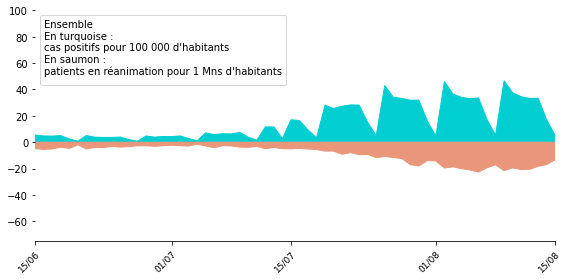

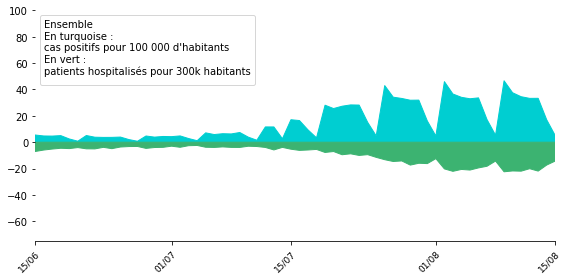

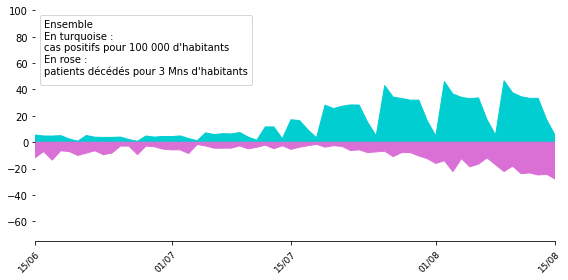

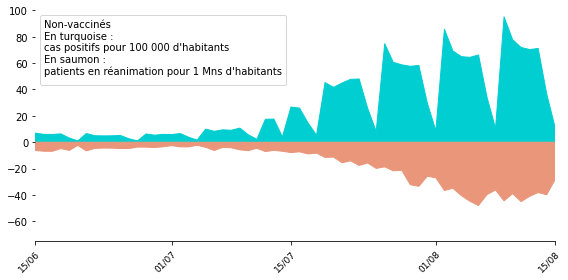

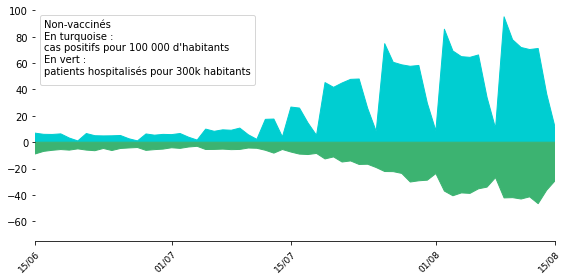

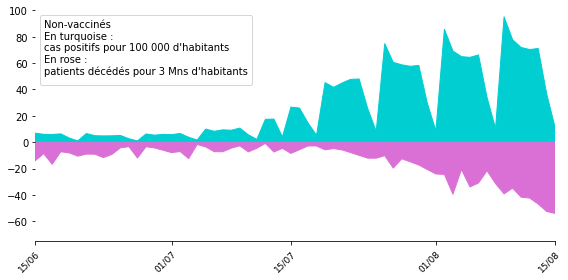

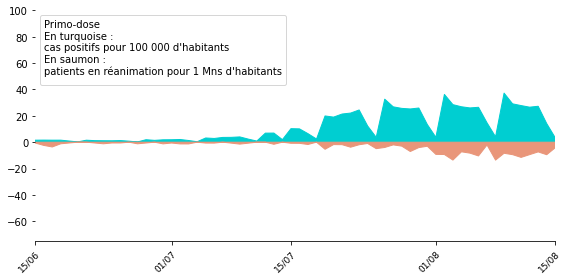

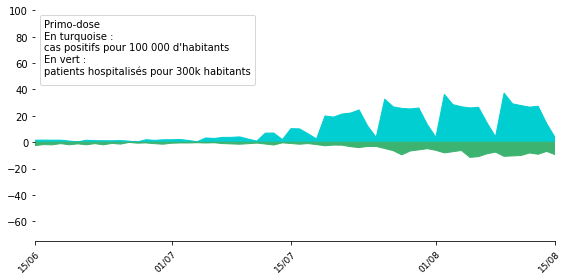

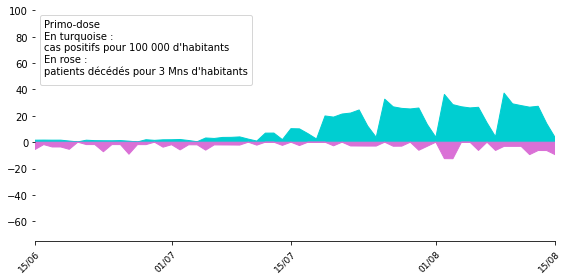

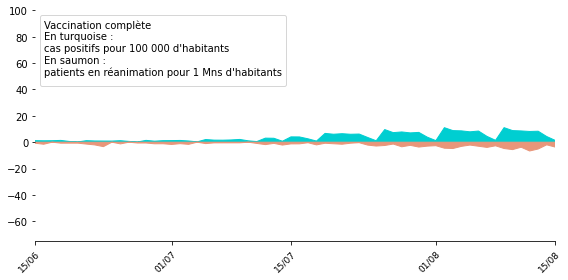

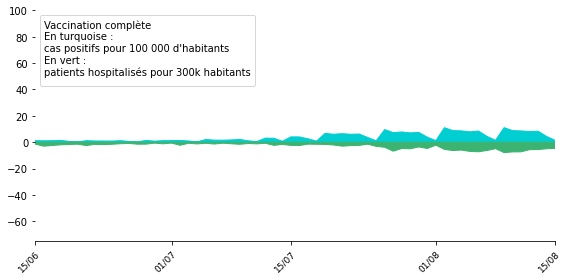

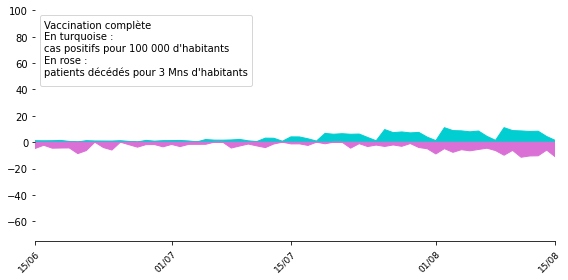

In [15]:
vac_statuts = ['Ensemble', 'Non-vaccinés', 'Primo-dose', 'Vaccination complète']
for vac_statut in vac_statuts:
    for label, coeff, color, title_part in zip(
        ['SC_odds', 'HC_odds', 'DC_odds'], 
        [-100, -30, -300], 
        ['darksalmon', 'mediumseagreen', 'orchid'],
        ['En saumon :\npatients en réanimation', 'En vert :\npatients hospitalisés', 'En rose :\npatients décédés']
        ):
        plt.rcParams["figure.facecolor"] = (1,1,1,1)
        plot_Burn_Murdoch(df, vac_statut, label, coeff, color, title_part)

In [17]:
df

,date,vac_statut,effectif J-7,HC_odds,SC_odds,DC_odds,PCR_odds,PCR_pos_odds,positivity,Effectif en Mns
0,2021-05-31,Non-vaccinés,43710767,51.703508,14.412925,3.660425,44385.860353,2225.309842,5.013556,43.710767
283,2021-05-31,Vaccination complète,9921162,21.166875,8.063572,1.007946,35347.673992,509.012956,1.440018,9.921162
0,2021-05-31,Primo-dose,13775312,27.585582,2.903745,5.807491,30094.418188,765.136935,2.542455,13.775312
228,2021-05-31,Primo dose efficace,8257915,31.484945,1.210959,9.687675,33973.466668,554.619417,1.632508,8.257915
165,2021-05-31,Primo dose récente,5517397,21.749387,5.437347,0.000000,24288.627409,1080.219531,4.447429,5.517397
...,...,...,...,...,...,...,...,...,...,...
282,2021-08-15,Primo dose récente,4720589,40.249215,2.118380,0.000000,5202.740590,324.112097,6.229642,4.720589
164,2021-08-15,Primo dose efficace,4762418,23.097511,6.299321,6.299321,8407.493840,354.861753,4.220779,4.762418
136,2021-08-15,Non-vaccinés,22751731,97.135466,28.129728,18.020607,11644.828255,1073.324926,9.217181,22.751731
76,2021-08-15,Primo-dose,9483007,31.635535,4.218071,3.163554,6812.185207,339.554742,4.984520,9.483007


# Autres graphes

In [22]:
def plot_pop_vaccin(df, label, title, dominante):
    plt.rcParams["figure.facecolor"] = (1,1,1,1)
    fig, ax = plt.subplots(figsize = (8,4))
    populations = ['Non-vaccinés', 'Primo-dose', 'Vaccination complète']
#     colors = ['red', 'orange', 'green']
    colors = [dominante, 'black', 'firebrick']
    linewidths = [3,                 1.5,            1]
    for population, color, linewidth in zip(populations, colors, linewidths):  
        df_pop = df[df.vac_statut == population]
        ax.plot(df_pop.date, df_pop[label], c = color, label = population, linewidth = linewidth)
    plt.legend(title = title)
    ax.xaxis.set_tick_params(bottom = True, labelsize = 10)                     
    xloc = [dt.datetime(2021, 6, 15),
           dt.datetime(2021, 7, 1), dt.datetime(2021, 7, 15),
           dt.datetime(2021, 8, 1), dt.datetime(2021, 8, 15), dt.datetime(2021, 9, 1)]
    labels = ['15/06',
                  '01/07', '15/07', '01/08', '15/08', '01/09']
    ax.xaxis.set_ticks(xloc)
    ax.xaxis.set_ticklabels(labels, rotation=45, ha="right", rotation_mode="anchor")
#     plt.title(label = title)
   # plt.tight_layout()
    save_output(fig, './', title, with_SVG = True)

In [23]:
df

,date,vac_statut,effectif J-7,HC_odds,SC_odds,DC_odds,PCR_odds,PCR_pos_odds,positivity,Effectif en Mns
0,2021-05-31,Non-vaccinés,43710767,51.703508,14.412925,3.660425,44385.860353,2225.309842,5.013556,43.710767
283,2021-05-31,Vaccination complète,9921162,21.166875,8.063572,1.007946,35347.673992,509.012956,1.440018,9.921162
0,2021-05-31,Primo-dose,13775312,27.585582,2.903745,5.807491,30094.418188,765.136935,2.542455,13.775312
228,2021-05-31,Primo dose efficace,8257915,31.484945,1.210959,9.687675,33973.466668,554.619417,1.632508,8.257915
165,2021-05-31,Primo dose récente,5517397,21.749387,5.437347,0.000000,24288.627409,1080.219531,4.447429,5.517397
...,...,...,...,...,...,...,...,...,...,...
282,2021-08-15,Primo dose récente,4720589,40.249215,2.118380,0.000000,5202.740590,324.112097,6.229642,4.720589
164,2021-08-15,Primo dose efficace,4762418,23.097511,6.299321,6.299321,8407.493840,354.861753,4.220779,4.762418
136,2021-08-15,Non-vaccinés,22751731,97.135466,28.129728,18.020607,11644.828255,1073.324926,9.217181,22.751731
76,2021-08-15,Primo-dose,9483007,31.635535,4.218071,3.163554,6812.185207,339.554742,4.984520,9.483007


In [24]:
df[df['date'] ==  '2021-08-01T00:00:00.000000000']

,date,vac_statut,effectif J-7,HC_odds,SC_odds,DC_odds,PCR_odds,PCR_pos_odds,positivity,Effectif en Mns
62,2021-08-01,Ensemble,57669842,41.616206,14.218870,5.375427,8121.575918,472.864136,5.822320,57.669842
160,2021-08-01,Primo dose efficace,5687618,17.582053,5.274616,0.000000,5824.934094,251.423355,4.316330,5.687618
69,2021-08-01,Primo dose récente,4049781,24.692693,14.815616,0.000000,7726.343721,545.708521,7.062959,4.049781
62,2021-08-01,Primo-dose,9737399,20.539366,9.242715,0.000000,6615.729724,373.816458,5.650419,9.737399
304,2021-08-01,Vaccination complète,30296438,7.591652,2.640574,2.970646,5079.805091,119.485994,2.352177,30.296438
222,2021-08-01,Non-vaccinés,27373404,79.274028,27.033540,8.036998,11488.158360,863.977312,7.520590,27.373404


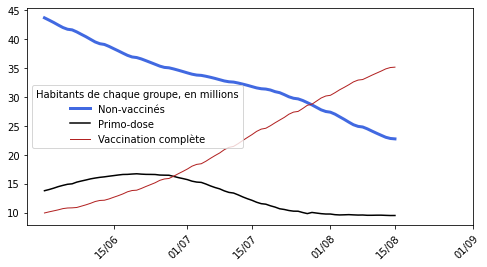

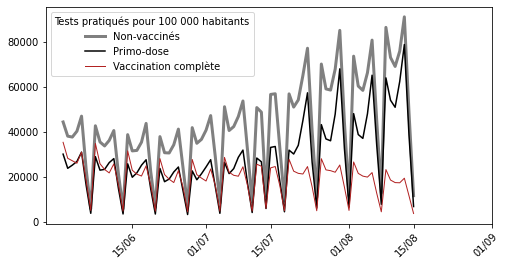

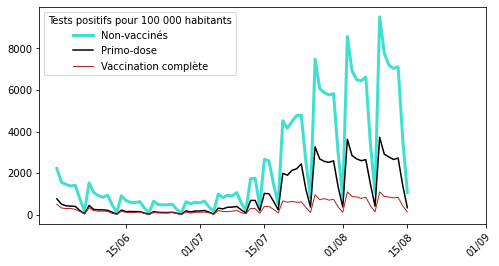

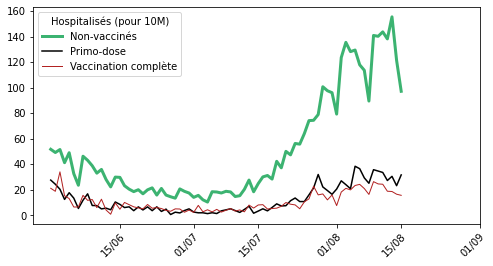

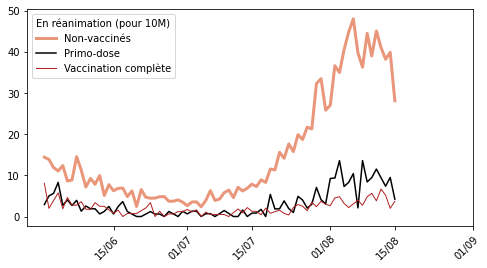

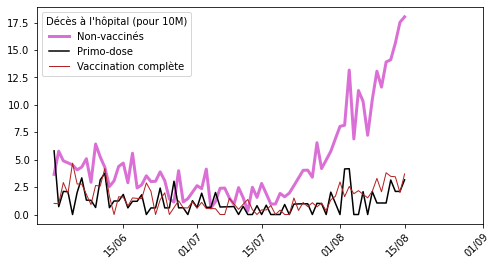

In [25]:
labels = ['Effectif en Mns', 'PCR_odds', 'PCR_pos_odds', 'HC_odds', 'SC_odds', 'DC_odds']
colors = ['royalblue', 'gray', 'turquoise', 'mediumseagreen', 'darksalmon', 'orchid']
titles = ['Habitants de chaque groupe, en millions',
          'Tests pratiqués pour 100 000 habitants',
          'Tests positifs pour 100 000 habitants',
          'Hospitalisés (pour 10M)',
          'En réanimation (pour 10M)',
          'Décès à l\'hôpital (pour 10M)'
         ]

for label, title, color in zip(labels, titles, colors):
    plot_pop_vaccin(df, label, title, color)

In [26]:
dic = [{'a': []}]

In [28]:
dic[0]['a'].append(5)

In [29]:
dic

[{'a': [5]}]

In [30]:
print(f'"{3} {4}"')

"3 4"


In [ ]:
def pizza_time(number):
    # Code the rest of the function below
    for i in range(1, number + 1):
          dividable_by_3 = (i%3 == 0)
          dividable_by_5 = (i%5 == 0)
          if dividable_by_3 and dividable_by_5:
             print("PizzaTime")
                  elif dividable_by_3:
        print("Pizza")
      elif dividable_by_5:
        print("Time")
      else:
        print(i)